IMPORTS

In [1]:
#Imports. Same as previous competition by default. Will add more later if needed
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

LOAD & CLEAN DATA

train.csv's shape is  (370703, 24)
test.csv's shape is  (92676, 23)

        id                         trans_num  trans_date trans_time  \
0   308467  26ad750c2ff71f32631b58913582d70a  2024-01-10   06:49:39   
1   261578  fea9c1efe3f2b97f27ad0ab5409ec861  2024-01-06   02:37:50   
2      341  2ae350b982be840f3666273e0c2f3a05  2024-01-18   21:40:21   
3  1147639  bbdd8adfc0a34ed0e817f809193c85c0  2024-01-21   16:20:15   
4   314152  fc7756004dc2a9bc450eb894a670b804  2024-01-21   19:36:26   

    unix_time        category     amt            cc_num    first     last  \
0  1704887379        misc_pos  188.38      676355457570   Andrea  Johnson   
1  1704526670     grocery_pos  102.63   377178373574671   Rhonda   Chavez   
2  1705632021   entertainment    1.62  3599292013370451  Stephen     Khan   
3  1705872015  health_fitness    5.64  3594292572430345   Justin   Reilly   
4  1705883786  health_fitness   97.09  4867547663675548    Alice   Duarte   

   ...    zip      lat      long city_pop

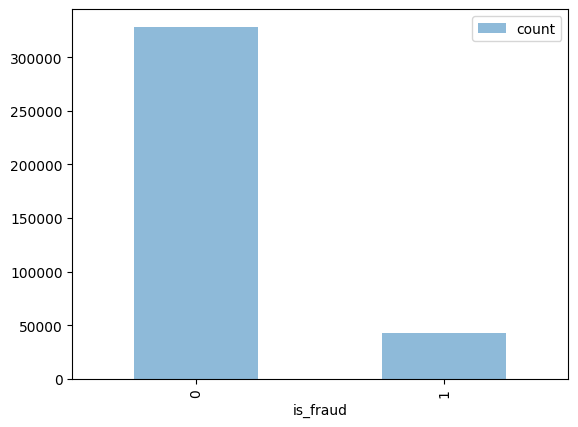

is_fraud
0    328404
1     42299
Name: count, dtype: int64


In [35]:
#Load & clean data
trainset = pd.read_csv('./data/train.csv')
testset = pd.read_csv('./data/test.csv')

#Verify shape matches the csv files
print("train.csv's shape is ", trainset.shape)
print("test.csv's shape is ", testset.shape)

print()

print(trainset.head())
print()
print(testset.head())

print()

#Real quick just check if data is skewed
trainset['is_fraud'].value_counts().plot(kind='bar',legend=True,alpha=.5)
plt.show()

print(trainset['is_fraud'].value_counts())



We know that there are proportionately more normal transactions than fraudulent transaction in this data set. Keep that in mind when building the model. ~11.41% of transactions in trainingset are fraudulent

FEATURE EXPLORING & ENGINEERING 

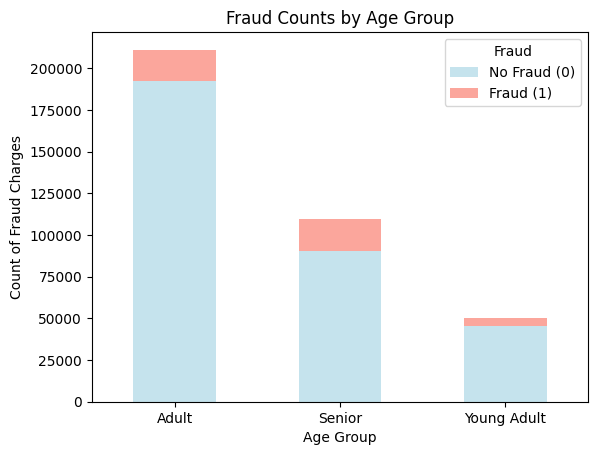

is_fraud          0      1
age_group                 
Adult        192417  18596
Senior        90429  19115
Young Adult   45558   4588

# fraud cases in group/TOTAL SAMPLE
is_fraud            0         1
age_group                      
Adult        0.519060  0.050164
Senior       0.243939  0.051564
Young Adult  0.122896  0.012376

# fraud cases in group/TOTAL POPULATION OF SPECIFIC AGE GROUP
age_group
Adult          0.088127
Senior         0.174496
Young Adult    0.091493
Name: is_fraud, dtype: float64


In [6]:
df = trainset
df['dob'] = pd.to_datetime(df['dob'])
def calculate_age(dob):
  today = datetime.today()
  return today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))

df['age'] = df['dob'].apply(calculate_age)

def classify_age_group(age):
    if age < 13:
        return 'Child'
    elif 13 <= age < 18:
        return 'Teen'
    elif 18 <= age < 30:
        return 'Young Adult'
    elif 30 <= age < 50:
        return 'Adult'
    else:
        return 'Senior'

df['age_group'] = df['age'].apply(classify_age_group)

age_fraud_counts = df.groupby(['age_group', 'is_fraud']).size().unstack(fill_value=0)

# Plot the histogram (stacked bar chart) showing the count of fraud by age group
age_fraud_counts.plot(kind='bar', stacked=True, color=['lightblue', 'salmon'], alpha=0.7)

plt.title('Fraud Counts by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count of Fraud Charges')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Fraud', labels=['No Fraud (0)', 'Fraud (1)'])
plt.show()

print(age_fraud_counts)
print()
print("# fraud cases in group/TOTAL SAMPLE")
print(age_fraud_counts/370703) #Fraud/total number within TOTAL SAMPLE
print()
print("# fraud cases in group/TOTAL POPULATION OF SPECIFIC AGE GROUP")
print(df.groupby('age_group')['is_fraud'].mean())
#Seniors have almost the same amount of fraud cases as normal adults despite making up less of the total sample size

Older ppl more susceptible to fraud

104
2906700
                                merchant  merchant_fraud_ratio
0               fraud_Turcotte-Halvorson              0.061644
1              fraud_Schamberger-O'Keefe              0.205224
2       fraud_Nicolas, Hills and McGlynn              0.060948
3                      fraud_Cormier LLC              0.177943
4                      fraud_Kulas Group              0.037129
...                                  ...                   ...
5476                   fraud_Mante Group              0.237467
5877             fraud_Emmerich-Luettgen              0.051118
5884  fraud_Hahn, Douglas and Schowalter              0.034632
6705                    fraud_Turner LLC              0.042254
8770              fraud_Satterfield-Lowe              0.069124

[693 rows x 2 columns]


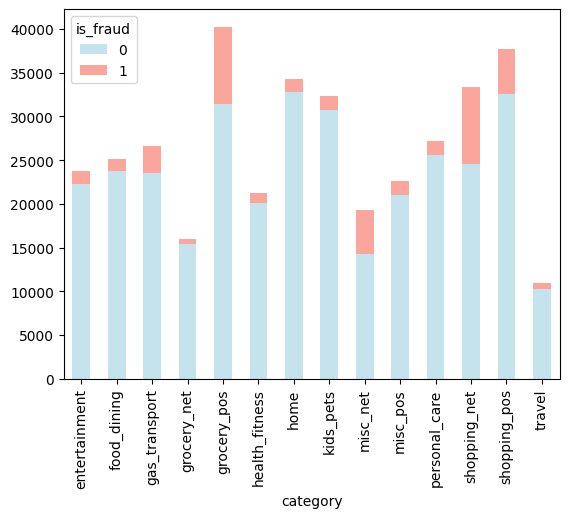

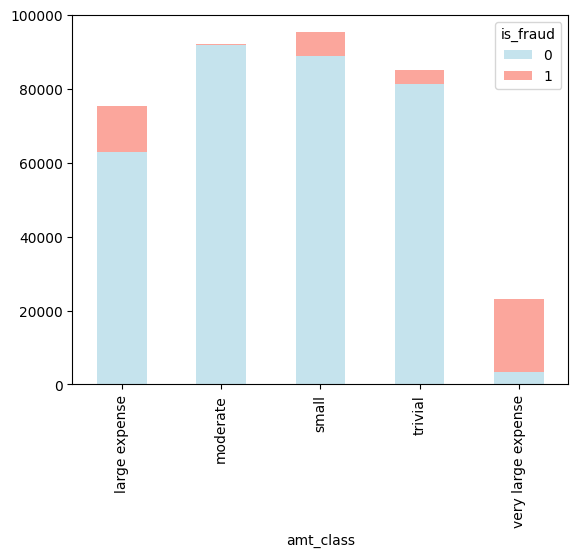

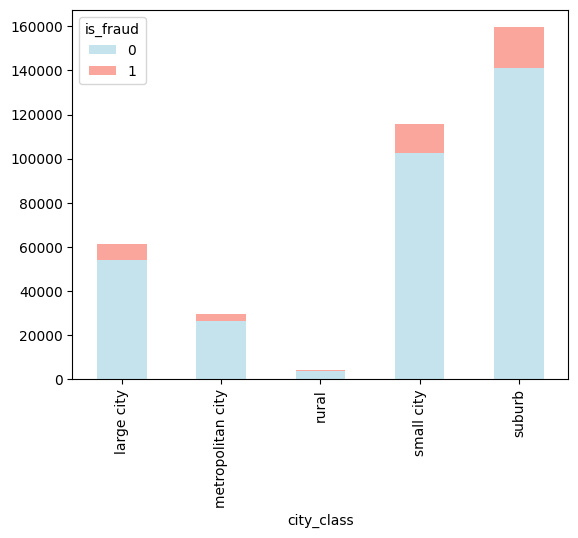

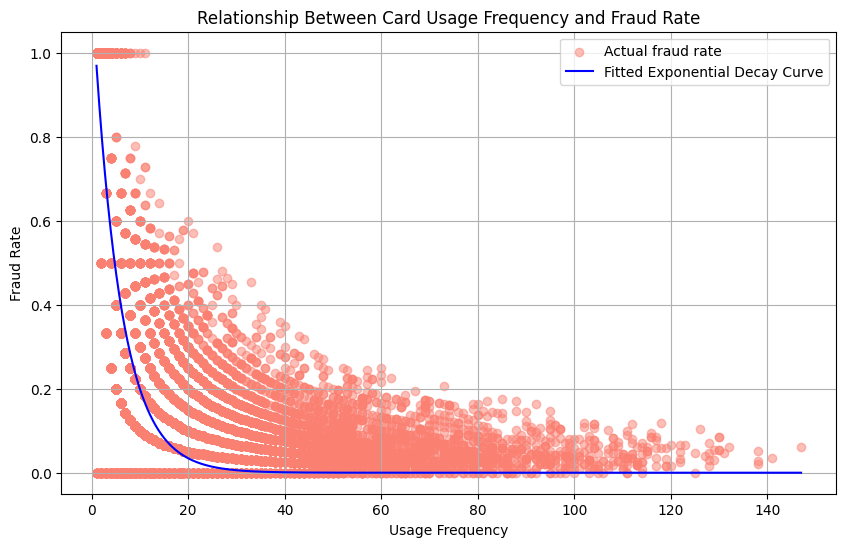

Exponential Decay Parameters: a = 1.154985734567364, b = 0.17572183111565126


In [12]:
spending_category_fraud_count = df.groupby(['category', 'is_fraud']).size().unstack(fill_value=0)
spending_category_fraud_count.plot(kind='bar', stacked=True, color=['lightblue', 'salmon'], alpha=0.7)

def classify_amt(amt):
  if amt < 10:
    return 'trivial'
  elif 10 < amt <= 50:
    return 'small'
  elif 50 < amt <= 100:
    return 'moderate'
  elif 100 < amt <= 500:
    return 'large expense'
  else:
    return 'very large expense'
  
df['amt_class'] = df['amt'].apply(classify_amt)
amt_fraud_counts = df.groupby(['amt_class', 'is_fraud']).size().unstack(fill_value=0)
amt_fraud_counts.plot(kind='bar', stacked=True, color=['lightblue', 'salmon'], alpha=0.7)

print(df['city_pop'].min())
print(df['city_pop'].max())

def classify_city_size(pop):
  if pop < 1000:
    return 'rural'
  elif 1000 < pop < 50000:
    return 'suburb'
  elif 50000 <= pop < 250000:
    return 'small city'
  elif 250000 <= pop < 1000000:
    return 'large city'
  else:
    return 'metropolitan city'
df['city_class'] = df['city_pop'].apply(classify_city_size)
citysize_fraud_counts = df.groupby(['city_class', 'is_fraud']).size().unstack(fill_value=0)
citysize_fraud_counts.plot(kind='bar', stacked=True, color=['lightblue', 'salmon'], alpha=0.7)

#Groups data by unique merchant & finds its ratio by taking the avg # of fraud purchases at particular merchant
merchant_fraud_ratios = (df.groupby('merchant')['is_fraud'].mean())
df['merchant_fraud_ratio'] = df['merchant'].map(merchant_fraud_ratios)
print(df[['merchant', 'merchant_fraud_ratio']].drop_duplicates())


#Are there particular credit card numbers that get used a lot? If so, what is the rate of fraud on them. Perhaps someone who uses their card a lot is more likely to have it stolen
def exp_decay(x, a, b):
    return a * np.exp(-b * x)

# Group by 'cc_num' and calculate usage frequency and fraud rate
card_stats = df.groupby('cc_num').agg(
    usage_frequency=('cc_num', 'size'),  # Count the number of transactions
    fraud_rate=('is_fraud', 'mean')  # Calculate the fraud rate
).reset_index()

# Prepare data
X = card_stats['usage_frequency']
y = card_stats['fraud_rate']

# Fit the exponential decay model to the data
from scipy.optimize import curve_fit
params, covariance = curve_fit(exp_decay, X, y, p0=[1, 0.001])  # Initial guess for parameters a and b

# Use the fitted model to predict fraud rate for a smooth range of usage frequencies
X_smooth = np.linspace(X.min(), X.max(), 500)  # Smooth range for usage frequencies
y_smooth = exp_decay(X_smooth, *params)  # Predicted fraud rates based on the fitted model

# Plotting the actual data and the predicted fraud rate curve
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, color='salmon', label='Actual fraud rate')
plt.plot(X_smooth, y_smooth, color='blue', label='Fitted Exponential Decay Curve')
plt.title('Relationship Between Card Usage Frequency and Fraud Rate')
plt.xlabel('Usage Frequency')
plt.ylabel('Fraud Rate')
plt.grid(True)
plt.legend()
plt.show()

# Print the decay parameters (slope)
a, b = params
print(f"Exponential Decay Parameters: a = {a}, b = {b}")

-Category is worth considering since certain categories have marginally higher fraudulent purchases. Perhaps ppl are going to grocery stores & buying gift cards with stolen credit cards.
-The amount of money spent is definitely worth consdering, with expenses over 500$ being mostly fraudulent charges.

In [ ]:
from sklearn.metrics import f1_score, classification_report
from scipy.optimize import curve_fit

trainset = pd.read_csv('./data/train.csv')
testset = pd.read_csv('./data/test.csv')

#Exponential decay function
def exp_decay(x, A, B):
    return A * np.exp(-B * x)

#Fit exponential decay model to the training data - relationship between card usage and fraud
def fit_fraud_rate_model(train_df):
    fraud_rate_per_card = train_df.groupby('cc_num')['is_fraud'].mean()
    card_counts = train_df['cc_num'].value_counts()

    #Merge the fraud rate with the number of purchases (occurrences)
    data = pd.DataFrame({
        'cc_num_occurences': card_counts,
        'fraud_rate': fraud_rate_per_card
    })

    params, _ = curve_fit(exp_decay, data['cc_num_occurences'], data['fraud_rate'], p0=(1, 0.01))

    return params

def define_features(train_df, test_df, params):
    #WANT NUMERICAL VALUES: AGE, CITY POP, AMOUNT, MERCHANT FRAUD RATIO, DISTANCE BETWEEN TRANSACTION & MERCHANT LOCATION, CATEGORY AVERAGE
    # Add the same feature to test data
    dataframes = [train_df, test_df]
    
    for df in dataframes:
        df['dob'] = pd.to_datetime(df['dob'])
        df['trans_date'] = pd.to_datetime(df['trans_date'])
        df['age'] = (df['trans_date'] - df['dob']).dt.days // 365

        #What years, months, days of the weeks, or hours of day are more likely for fraud to happen? 
        df['transaction_year'] = df['trans_date'].dt.year
        df['transaction_month'] = df['trans_date'].dt.month
        df['transaction_day'] = df['trans_date'].dt.day
        df['transaction_hour'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S').dt.hour

        df['distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)

    #Individual merchant fraud data
    merchant_fraud_ratios = train_df.groupby('merchant')['is_fraud'].mean()
    train_df['merchant_fraud_ratio'] = train_df['merchant'].map(merchant_fraud_ratios)
    test_df['merchant_fraud_ratio'] = test_df['merchant'].map(merchant_fraud_ratios).fillna(0)

    #Category fraud data
    category_fraud_avg = train_df.groupby('category')['is_fraud'].mean()
    train_df['category_fraud_avg'] = train_df['category'].map(category_fraud_avg)
    test_df['category_fraud_avg'] = test_df['category'].map(category_fraud_avg).fillna(0)

    #Job fraud data
    job_fraud_avg = train_df.groupby('job')['is_fraud'].mean()
    train_df['job_fraud_avg'] = train_df['job'].map(job_fraud_avg)
    test_df['job_fraud_avg'] = test_df['job'].map(job_fraud_avg).fillna(0)

    #Number of times a particular credit card appears
    train_cc_counts = train_df['cc_num'].value_counts()
    test_cc_counts = test_df['cc_num'].value_counts()
    #Map the number of occurences for each credit card number row
    train_df['cc_num_occurences'] = train_df['cc_num'].map(train_cc_counts)
    test_df['cc_num_occurences'] = test_df['cc_num'].map(test_cc_counts)

    #Exponential decay formula between number of purchases on a card vs the number of fraud cases on that card
    params = fit_fraud_rate_model(train_df)
    train_df['fraud_rate_estimate'] = train_df['cc_num_occurences'].map(lambda x: exp_decay(x, *params))
    test_df['fraud_rate_estimate'] = test_df['cc_num_occurences'].map(lambda x: exp_decay(x, *params))
   


    drop_cols = ['trans_num', 'trans_date', 'trans_time', 'unix_time', 'first', 'last', 'street', 
                 'city', 'state', 'zip', 'dob', 'merchant', 'lat', 'long', 'merch_lat', 'merch_long']
    trainset.drop(columns=drop_cols, inplace=True)
    test_df.drop(columns=drop_cols, inplace=True)


    # Encode categorical variables
    categorical_cols = ['category', 'gender', 'job']
    for col in categorical_cols:
        train_df[col] = LabelEncoder().fit_transform(train_df[col])
    for col in categorical_cols:
        test_df[col] = LabelEncoder().fit_transform(test_df[col])

    return train_df, test_df

train = trainset
test = testset
params = fit_fraud_rate_model(train)
alterted_train, altered_test = define_features(train, test, params)
X = alterted_train.drop(columns=['is_fraud'])
y = alterted_train['is_fraud']
X_test = altered_test


#Balance skeweed data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#Scaling numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#Define xgboost model & train
model = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train)

#Model Eval
y_val_pred = model.predict(X_val)
print("Validation F1-Score:", f1_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

#Submission file - follow format of Kaggle Comp columns: ID, is_fraud 
test['is_fraud'] = model.predict(X_test)
submission = test[['id', 'is_fraud']]
submission.to_csv("submission.csv", index=False)

print("Submission file created - 'submission.csv'")



C:\Users\Ilay2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:15:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation F1-Score: 0.9787071517234794
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     82101
           1       0.99      0.97      0.98     10575

    accuracy                           1.00     92676
   macro avg       0.99      0.98      0.99     92676
weighted avg       1.00      1.00      1.00     92676

Submission file created - 'submission.csv'
